# Thermodynamic Consistency: Activity Coefficients with the Gibbs-Duhem Constraint

In thermodynamics, the **Gibbs-Duhem equation** relates the activity coefficients of
components in a mixture. For a binary system at constant temperature and pressure:

$$x_1 \frac{d \ln \gamma_1}{d x_1} + x_2 \frac{d \ln \gamma_2}{d x_1} = 0$$

This is a fundamental consistency requirement: if we know one activity coefficient as a
function of composition, the other is not free — it must satisfy Gibbs-Duhem.

This example demonstrates **four levels of constraint enforcement**, each trading off
implementation complexity, domain knowledge requirements, and constraint satisfaction:

1. **Unconstrained** — baseline showing constraint violations
2. **Refit-only** — penalty-based coefficient adjustment (approximate, one model)
3. **Constraint-aware** — penalty-based term selection and coefficients (approximate, iterative)
4. **Hard equality constraint** — analytical null-space projection (exact, advanced)

We work through all four approaches to show:
- Why refit-only constraints have limited effect on coupled constraints
- How constraint-aware term selection recovers the correct model structure
- How to achieve exact (machine precision) constraint satisfaction via analytical methods
- When to use each level based on your requirements

## Background: The Margules Model

The two-suffix Margules model gives activity coefficients for a binary mixture:

$$\ln \gamma_1 = x_2^2 \left[ A_{12} + 2(A_{21} - A_{12}) x_1 \right]$$

$$\ln \gamma_2 = x_1^2 \left[ A_{21} + 2(A_{12} - A_{21}) x_2 \right]$$

where $A_{12}$ and $A_{21}$ are the Margules parameters. These expressions automatically
satisfy the Gibbs-Duhem equation — any deviation from it in a fit indicates model
inconsistency.

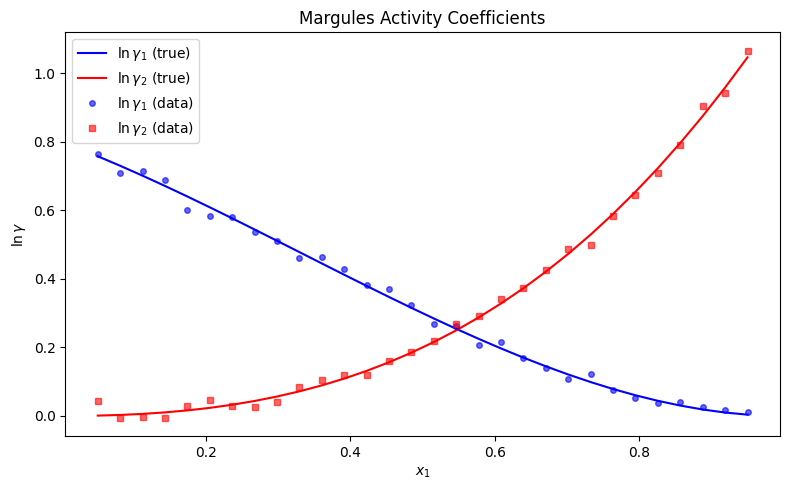

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Margules parameters
A12 = 0.8
A21 = 1.2

# Generate composition data (avoid x1=0 and x1=1 where derivatives are less informative)
rng = np.random.default_rng(42)
x1 = np.linspace(0.05, 0.95, 30)
x2 = 1.0 - x1

# True activity coefficients from Margules model
ln_gamma1_true = x2**2 * (A12 + 2 * (A21 - A12) * x1)
ln_gamma2_true = x1**2 * (A21 + 2 * (A12 - A21) * x2)

# Add measurement noise
noise_level = 0.02
ln_gamma1_data = ln_gamma1_true + rng.normal(0, noise_level, size=len(x1))
ln_gamma2_data = ln_gamma2_true + rng.normal(0, noise_level, size=len(x1))

# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x1, ln_gamma1_true, "b-", label=r"$\ln \gamma_1$ (true)")
ax.plot(x1, ln_gamma2_true, "r-", label=r"$\ln \gamma_2$ (true)")
ax.plot(x1, ln_gamma1_data, "bo", ms=4, alpha=0.6, label=r"$\ln \gamma_1$ (data)")
ax.plot(x1, ln_gamma2_data, "rs", ms=4, alpha=0.6, label=r"$\ln \gamma_2$ (data)")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma$")
ax.set_title("Margules Activity Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

## Step 1: Unconstrained Fits

First, let's fit polynomial models to each component independently, with no
thermodynamic constraints.

In [2]:
from jaxsr import BasisLibrary, SymbolicRegressor

# Build polynomial basis in x1 — include constant and linear terms so the
# true Margules expansion (which uses 1, x1, x1^2, x1^3) is recoverable.
library = (
    BasisLibrary(n_features=1, feature_names=["x1"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=4)
)
print("Basis functions:", library.names)

# Fit ln(gamma1)
X = x1.reshape(-1, 1)

model1_free = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
)
model1_free.fit(X, ln_gamma1_data)
print("ln(gamma1) unconstrained:", model1_free.expression_)

# Fit ln(gamma2)
model2_free = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
)
model2_free.fit(X, ln_gamma2_data)
print("ln(gamma2) unconstrained:", model2_free.expression_)

W0000 00:00:1772024840.838623 2483792 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1772024840.848353 2483792 service.cc:145] XLA service 0x9c7bf9b00 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772024840.848360 2483792 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1772024840.849236 2483792 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1772024840.849241 2483792 mps_client.cc:384] XLA backend will use up to 55662313472 bytes on device 0 for SimpleAllocator.


Basis functions: ['1', 'x1', 'x1^2', 'x1^3', 'x1^4']
Metal device set to: Apple M4 Pro


ln(gamma1) unconstrained: y = 0.8044 - 0.9616*x1 - 0.5047*x1^3 + 0.6848*x1^4
ln(gamma2) unconstrained: y = 0.686*x1^2 + 0.5409*x1^4


## Step 2: Check Gibbs-Duhem Violation

The Gibbs-Duhem equation requires:

$$x_1 \frac{d \ln \gamma_1}{d x_1} + x_2 \frac{d \ln \gamma_2}{d x_1} = 0$$

Since our models are built from JAX-differentiable basis functions, we compute
**exact analytical derivatives** using `jax.grad` — no finite-difference approximation
needed.

Max |residual|: 0.177319


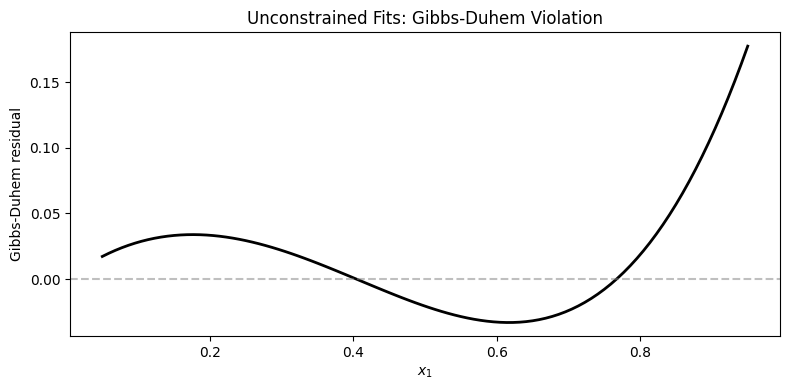

In [3]:
import jax
import jax.numpy as jnp


def model_derivative(model, x1_vals):
    """Compute exact d(prediction)/dx1 using JAX autodiff.

    The model predicts y = Phi(X) @ coefficients, where Phi is the basis
    matrix from library.evaluate(). Since library.evaluate uses pure JAX
    operations, jax.grad gives the exact analytical derivative.
    """
    coeffs = jnp.array(model.coefficients_)
    basis_lib = model.basis_library
    indices = list(model.selected_indices_)

    def predict_scalar(x):
        """Predict at a single scalar x1 value."""
        X_single = jnp.array([[x]])
        Phi = basis_lib.evaluate_subset(X_single, indices)
        return (Phi @ coeffs)[0]

    grad_fn = jax.grad(predict_scalar)
    return jax.vmap(grad_fn)(jnp.array(x1_vals))


def gibbs_duhem_residual(model1, model2, x1_eval):
    """Compute the Gibbs-Duhem residual: x1*d(ln g1)/dx1 + x2*d(ln g2)/dx1.

    Uses exact JAX autodiff derivatives. Should be zero for thermodynamically
    consistent models.
    """
    x2_eval = 1.0 - x1_eval
    d_lng1 = np.array(model_derivative(model1, x1_eval))
    d_lng2 = np.array(model_derivative(model2, x1_eval))
    return x1_eval * d_lng1 + x2_eval * d_lng2


x1_eval = np.linspace(0.05, 0.95, 100)
residual_free = gibbs_duhem_residual(model1_free, model2_free, x1_eval)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x1_eval, residual_free, "k-", lw=2)
ax.axhline(0, color="gray", ls="--", alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel("Gibbs-Duhem residual")
ax.set_title("Unconstrained Fits: Gibbs-Duhem Violation")
print(f"Max |residual|: {np.max(np.abs(residual_free)):.6f}")
plt.tight_layout()
plt.show()

## Step 3: Constrained Fit Using `add_custom()`

To enforce thermodynamic consistency, we:
1. Keep the `ln(gamma1)` fit as-is (the "anchor")
2. Constrain `ln(gamma2)` so that the Gibbs-Duhem equation is satisfied

We define a custom penalty function that evaluates the Gibbs-Duhem residual
using the fixed `ln(gamma1)` model and the current candidate `ln(gamma2)` predictions.
The penalty is the mean squared Gibbs-Duhem residual, weighted to strongly
discourage violations.

In [4]:
from jaxsr import Constraints

# Precompute exact ln(gamma1) derivative from the anchor model using autodiff
d_lng1_dx1 = model_derivative(model1_free, x1)


def gibbs_duhem_penalty(coefficients, X_data, y_pred):
    """Penalty for Gibbs-Duhem violation.

    Given the anchor model's d(ln gamma1)/dx1 (precomputed via autodiff),
    penalize candidate ln(gamma2) models whose derivative is inconsistent.

    Gibbs-Duhem: x1 * d(ln g1)/dx1 + x2 * d(ln g2)/dx1 = 0
    """
    x1_vals = X_data[:, 0]
    x2_vals = 1.0 - x1_vals

    # Exact derivative of ln(gamma2) = Phi @ coefficients w.r.t. x1
    # d/dx1 [Phi(x) @ c] = dPhi/dx1 @ c
    def predict_at(x_scalar):
        X_single = jnp.array([[x_scalar]])
        Phi = jnp.array(library.evaluate(X_single))
        return (Phi @ coefficients)[0]

    d_lng2_dx1 = jax.vmap(jax.grad(predict_at))(x1_vals)

    # Gibbs-Duhem residual
    residual = x1_vals * jnp.array(d_lng1_dx1) + x2_vals * d_lng2_dx1

    return jnp.mean(residual**2)


# Build constraints
constraints = Constraints()
constraints.add_custom("gibbs_duhem", gibbs_duhem_penalty, weight=100.0)

# Fit ln(gamma2) with Gibbs-Duhem constraint
model2_constrained = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
    constraints=constraints,
)
model2_constrained.fit(X, ln_gamma2_data)
print("ln(gamma2) constrained:", model2_constrained.expression_)

ln(gamma2) constrained: y = 0.7025*x1^2 + 0.4907*x1^4


## Step 4: Verification

Let's compare the unconstrained and constrained fits, and check whether the
Gibbs-Duhem residual is reduced.

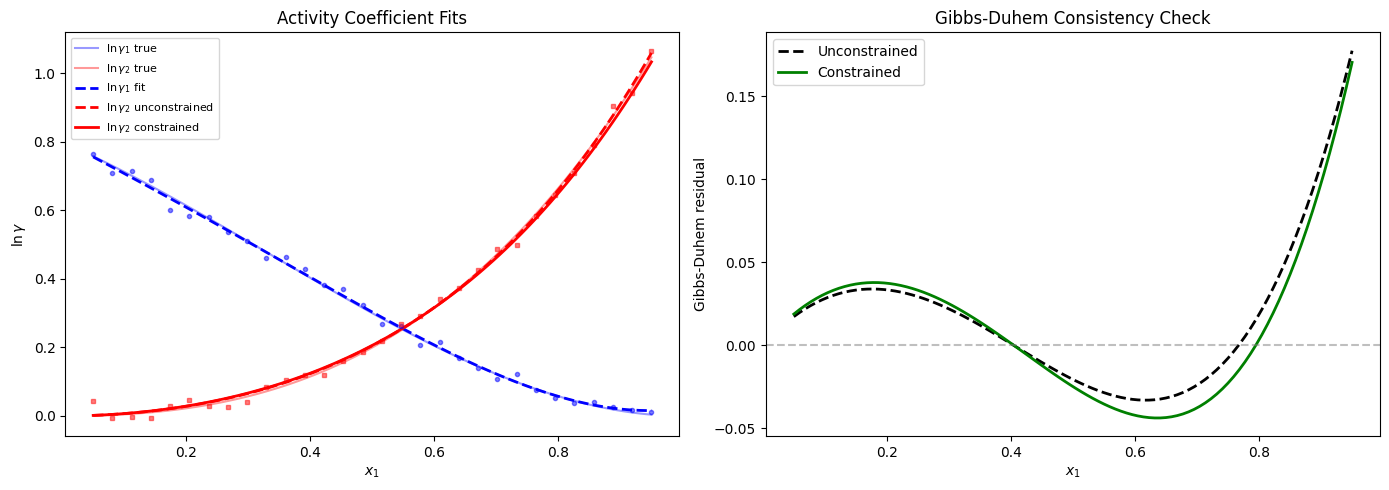

Max |GD residual| unconstrained: 0.1773
Max |GD residual| constrained:   0.1703


In [5]:
# Recompute true values on the evaluation grid
x2_eval = 1.0 - x1_eval
ln_gamma1_eval = x2_eval**2 * (A12 + 2 * (A21 - A12) * x1_eval)
ln_gamma2_eval = x1_eval**2 * (A21 + 2 * (A12 - A21) * x2_eval)

# Predictions
X_plot = x1_eval.reshape(-1, 1)
pred1 = model1_free.predict(X_plot)
pred2_free = model2_free.predict(X_plot)
pred2_con = model2_constrained.predict(X_plot)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Activity coefficient fits
ax = axes[0]
ax.plot(x1_eval, ln_gamma1_eval, "b-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_1$ true")
ax.plot(x1_eval, ln_gamma2_eval, "r-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_2$ true")
ax.plot(x1_eval, pred1, "b--", lw=2, label=r"$\ln \gamma_1$ fit")
ax.plot(x1_eval, pred2_free, "r--", lw=2, label=r"$\ln \gamma_2$ unconstrained")
ax.plot(x1_eval, pred2_con, "r-", lw=2, label=r"$\ln \gamma_2$ constrained")
ax.plot(x1, ln_gamma1_data, "bo", ms=3, alpha=0.5)
ax.plot(x1, ln_gamma2_data, "rs", ms=3, alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma$")
ax.set_title("Activity Coefficient Fits")
ax.legend(fontsize=8)

# Right: Gibbs-Duhem residual comparison
ax = axes[1]
residual_con = gibbs_duhem_residual(model1_free, model2_constrained, x1_eval)
ax.plot(x1_eval, residual_free, "k--", lw=2, label="Unconstrained")
ax.plot(x1_eval, residual_con, "g-", lw=2, label="Constrained")
ax.axhline(0, color="gray", ls="--", alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel("Gibbs-Duhem residual")
ax.set_title("Gibbs-Duhem Consistency Check")
ax.legend()

plt.tight_layout()
plt.show()

print(f"Max |GD residual| unconstrained: {np.max(np.abs(residual_free)):.4f}")
print(f"Max |GD residual| constrained:   {np.max(np.abs(residual_con)):.4f}")

## Why the Improvement Is Small

The constrained fit above only improved the Gibbs-Duhem residual slightly. This is
because the constraint has **two limitations** in the refit-only approach:

1. **Term selection is unaware of constraints.** `add_custom()` only affects
   the coefficient refit after terms have already been chosen by AICc alone.
   The search selected `{x1^2, x1^4}` for `ln(gamma2)`, but the true model
   uses `{x1^2, x1^3}`. No coefficient tuning can fix a structural mismatch.

2. **The anchor model is also wrong.** The unconstrained `ln(gamma1)` fit chose
   `{1, x1, x1^3, x1^4}`, but the true Margules expansion is
   `{1, x1, x1^2, x1^3}`. Since the Gibbs-Duhem penalty on `ln(gamma2)` is
   evaluated against model1's derivative, a structurally wrong anchor means
   the GD residual can never reach zero — no matter how good model2 is.

To fix both problems, we need constraint-aware selection on **both** models.
We do this iteratively:
1. Use the unconstrained `ln(gamma2)` as an initial anchor
2. Fit `ln(gamma1)` with GD-aware selection against that anchor
3. Use the improved `ln(gamma1)` as the anchor for `ln(gamma2)`

## Step 5: Constraint-Aware Term Selection (Iterative)

The `constraint_selection_weight` parameter adds the constraint penalty to the
information criterion *during term selection*:

$$\text{score} = \text{AICc} + w \cdot \text{penalty}(\text{coefficients}, \text{constraints})$$

This biases the search toward term sets that can satisfy the constraint, even if
their raw AICc is slightly worse.

Since the Gibbs-Duhem equation couples **both** activity coefficients, we apply
constraint-aware selection to both models in an iterative loop:

1. Use the unconstrained `ln(gamma2)` to build a GD penalty for `ln(gamma1)`
2. Fit `ln(gamma1)` with constraint-aware selection
3. Use the improved `ln(gamma1)` to build a GD penalty for `ln(gamma2)`
4. Fit `ln(gamma2)` with constraint-aware selection

In [6]:
def make_gd_penalty_for_component(anchor_model, component="gamma2"):
    """Build a Gibbs-Duhem penalty function using an anchor model.

    Uses JAX autodiff for exact derivatives — no finite-difference approximation.

    Parameters
    ----------
    anchor_model : SymbolicRegressor
        Fitted model for the OTHER component.
    component : str
        Which component this penalty constrains ("gamma1" or "gamma2").
    """
    # Precompute exact anchor derivative via autodiff
    d_anchor = model_derivative(anchor_model, x1)

    def penalty(coefficients, X_data, y_pred):
        x1_vals = X_data[:, 0]
        x2_vals = 1.0 - x1_vals

        # Exact derivative of candidate model w.r.t. x1
        def predict_at(x_scalar):
            X_single = jnp.array([[x_scalar]])
            Phi = jnp.array(library.evaluate(X_single))
            return (Phi @ coefficients)[0]

        d_candidate = jax.vmap(jax.grad(predict_at))(x1_vals)

        # GD: x1*d(lng1)/dx1 + x2*d(lng2)/dx1 = 0
        if component == "gamma2":
            residual = x1_vals * jnp.array(d_anchor) + x2_vals * d_candidate
        else:  # gamma1
            residual = x1_vals * d_candidate + x2_vals * jnp.array(d_anchor)

        return jnp.mean(residual**2)

    return penalty


def gd_max_residual(m1, m2):
    """Compute max |GD residual| for a pair of models."""
    return float(np.max(np.abs(gibbs_duhem_residual(m1, m2, x1_eval))))


# Two parameters control constraint strength:
#   weight (in add_custom): multiplier on the penalty during coefficient refit
#   constraint_selection_weight: multiplier on the penalty during term selection
#
# The true model {x1^2, x1^3} loses to {x1^2, x1^4} by only 0.51 AICc units.
# Both weights need to be large enough to overcome this small gap AND to
# break out of the bootstrapping local minimum (wrong anchor -> wrong penalty).
PENALTY_WEIGHT = 1000
CSW = 1000

# Iterate: alternately improve model1 and model2
cur_m1, cur_m2 = model1_free, model2_free
print(f"Initial:  GD={gd_max_residual(cur_m1, cur_m2):.6f}")
print(f"  m1: {cur_m1.expression_}")
print(f"  m2: {cur_m2.expression_}")

for iteration in range(5):
    # Improve model1 using current model2 as anchor
    c_g1 = Constraints()
    c_g1.add_custom("gibbs_duhem",
                     make_gd_penalty_for_component(cur_m2, "gamma1"),
                     weight=PENALTY_WEIGHT)
    cur_m1 = SymbolicRegressor(
        basis_library=library, max_terms=5, strategy="exhaustive",
        information_criterion="aicc", constraints=c_g1,
        constraint_selection_weight=CSW,
    )
    cur_m1.fit(X, ln_gamma1_data)

    # Improve model2 using improved model1 as anchor
    c_g2 = Constraints()
    c_g2.add_custom("gibbs_duhem",
                     make_gd_penalty_for_component(cur_m1, "gamma2"),
                     weight=PENALTY_WEIGHT)
    cur_m2 = SymbolicRegressor(
        basis_library=library, max_terms=5, strategy="exhaustive",
        information_criterion="aicc", constraints=c_g2,
        constraint_selection_weight=CSW,
    )
    cur_m2.fit(X, ln_gamma2_data)

    gd = gd_max_residual(cur_m1, cur_m2)
    print(f"\nIteration {iteration + 1}: GD={gd:.6f}")
    print(f"  m1: {cur_m1.expression_}")
    print(f"  m2: {cur_m2.expression_}")

model1_cs, model2_cs = cur_m1, cur_m2
print(f"\nTrue ln(gamma1) = 0.80 - 0.80*x1 - 0.80*x1^2 + 0.80*x1^3")
print(f"True ln(gamma2) = 0.40*x1^2 + 0.80*x1^3")

Initial:  GD=0.177319
  m1: y = 0.8044 - 0.9616*x1 - 0.5047*x1^3 + 0.6848*x1^4
  m2: y = 0.686*x1^2 + 0.5409*x1^4



Iteration 1: GD=0.007461
  m1: y = 0.8333 - 1.107*x1 + 0.2732*x1^4
  m2: y = 0.5693*x1^2 + 0.3044*x1^3 + 0.342*x1^4



Iteration 2: GD=0.005043
  m1: y = 0.8341 - 1.109*x1 + 0.2748*x1^4
  m2: y = 0.5653*x1^2 + 0.326*x1^3 + 0.3214*x1^4



Iteration 3: GD=0.019110
  m1: y = 0.8164 - 0.924*x1 - 0.5651*x1^2 + 0.6727*x1^3
  m2: y = 0.002875 + 0.503*x1^2 + 0.5196*x1^3 + 0.1762*x1^4



Iteration 4: GD=0.010489
  m1: y = 0.8125 - 0.8928*x1 - 0.628*x1^2 + 0.7097*x1^3
  m2: y = 0.003368 + 0.4689*x1^2 + 0.6255*x1^3 + 0.09677*x1^4



Iteration 5: GD=0.007428
  m1: y = 0.8102 - 0.8755*x1 - 0.6626*x1^2 + 0.73*x1^3
  m2: y = 0.4274*x1^2 + 0.7546*x1^3

True ln(gamma1) = 0.80 - 0.80*x1 - 0.80*x1^2 + 0.80*x1^3
True ln(gamma2) = 0.40*x1^2 + 0.80*x1^3


## Step 6: Exact Gibbs-Duhem Enforcement via Hard Equality Constraints

The iterative penalty approach recovered the correct term structure, but the GD
residual is still ~0.007 because the penalty only *approximately* enforces the constraint.

For polynomial models, the Gibbs-Duhem equation produces **linear equality constraints**
on the coefficients. If $m_1 = a + bx + cx^2 + dx^3$ and $m_2 = ex^2 + fx^3$, then
expanding $x \cdot m_1'(x) + (1-x) \cdot m_2'(x) = 0$ and setting each power of $x$
to zero gives:

$$b + 2e = 0$$
$$2c - 2e + 3f = 0$$
$$3d - 3f = 0 \implies d = f$$

These are 3 linear equations in 6 unknowns, leaving 3 degrees of freedom.
We solve the **joint constrained least squares** problem:

$$\min_{c} \| y - \Phi \, c \|^2 \quad \text{subject to} \quad A \, c = 0$$

by projecting onto the null space of $A$: parameterize $c = N z$ where $N$ spans
$\ker(A)$, then solve the unconstrained problem $\min_z \| y - \Phi N z \|^2$.

Now let's implement the hard equality constraint approach. We use the term structure
discovered by the constraint-aware iteration (iteration 5): `{1, x1, x1^2, x1^3}` for
ln(gamma1) and `{x1^2, x1^3}` for ln(gamma2).

We build a joint model with 6 coefficients `[a0, a1, a2, a3, b2, b3]` and derive the
linear equality constraints from the Gibbs-Duhem equation.

In [ ]:
from scipy.linalg import null_space

# Build joint basis matrices for both models
# Model1 terms: [1, x1, x1^2, x1^3]
# Model2 terms: [x1^2, x1^3]
Phi1 = np.column_stack([
    np.ones_like(x1),
    x1,
    x1**2,
    x1**3
])

Phi2 = np.column_stack([
    x1**2,
    x1**3
])

# Stack into joint design matrix and response vector
# Coefficient vector: [a0, a1, a2, a3, b2, b3]
Phi_joint = np.block([
    [Phi1, np.zeros((len(x1), 2))],
    [np.zeros((len(x1), 4)), Phi2]
])
y_joint = np.concatenate([ln_gamma1_data, ln_gamma2_data])

# Derive constraint matrix from Gibbs-Duhem equation
# m1 = a0 + a1*x1 + a2*x1^2 + a3*x1^3
# m2 = b2*x1^2 + b3*x1^3
# d(m1)/dx1 = a1 + 2*a2*x1 + 3*a3*x1^2
# d(m2)/dx1 = 2*b2*x1 + 3*b3*x1^2
#
# GD: x1*(a1 + 2*a2*x1 + 3*a3*x1^2) + (1-x1)*(2*b2*x1 + 3*b3*x1^2) = 0
# Expanding and collecting powers:
#   x1^1: a1 + 2*b2 = 0
#   x1^2: 2*a2 - 2*b2 + 3*b3 = 0
#   x1^3: 3*a3 - 3*b3 = 0
A = np.array([
    [0, 1, 0, 0, 2, 0],     # a1 + 2*b2 = 0
    [0, 0, 2, 0, -2, 3],    # 2*a2 - 2*b2 + 3*b3 = 0
    [0, 0, 0, 3, 0, -3],    # 3*a3 - 3*b3 = 0
])

print("Constraint matrix A (3 equations, 6 unknowns):")
print(A)
print()

# Find null space: N such that A @ N = 0
N = null_space(A)
print(f"Null space dimension: {N.shape[1]} (should be 3)")
print()

# Solve unconstrained problem in null space: min_z ||y - Phi*N*z||^2
Phi_reduced = Phi_joint @ N
z_opt = np.linalg.lstsq(Phi_reduced, y_joint, rcond=None)[0]
coeffs_hard = N @ z_opt

print("Hard constraint coefficients [a0, a1, a2, a3, b2, b3]:")
print(coeffs_hard)
print()

# Extract individual model coefficients
a0, a1, a2, a3 = coeffs_hard[:4]
b2, b3 = coeffs_hard[4:]

print(f"ln(gamma1) = {a0:.4f} + {a1:.4f}*x1 + {a2:.4f}*x1^2 + {a3:.4f}*x1^3")
print(f"ln(gamma2) = {b2:.4f}*x1^2 + {b3:.4f}*x1^3")
print()

# Verify constraints are satisfied
print("Constraint verification (should all be ~0):")
print(f"  a1 + 2*b2 = {a1 + 2*b2:.2e}")
print(f"  2*a2 - 2*b2 + 3*b3 = {2*a2 - 2*b2 + 3*b3:.2e}")
print(f"  3*a3 - 3*b3 = {3*a3 - 3*b3:.2e}")
print()

# Create wrapper models for compatibility with existing functions
class HardConstraintModel:
    """Wrapper to make hard constraint coefficients compatible with existing code."""
    def __init__(self, coeffs, terms):
        self.coefficients_ = coeffs
        self.terms = terms
        self.basis_library = library
        self.selected_indices_ = terms
        
    def predict(self, X):
        x = X[:, 0]
        if len(self.coefficients_) == 4:  # model1
            return self.coefficients_[0] + self.coefficients_[1]*x + \
                   self.coefficients_[2]*x**2 + self.coefficients_[3]*x**3
        else:  # model2
            return self.coefficients_[0]*x**2 + self.coefficients_[1]*x**3
    
    @property
    def expression_(self):
        if len(self.coefficients_) == 4:
            return f"y = {self.coefficients_[0]:.4f} + {self.coefficients_[1]:.4f}*x1 + " \
                   f"{self.coefficients_[2]:.4f}*x1^2 + {self.coefficients_[3]:.4f}*x1^3"
        else:
            return f"y = {self.coefficients_[0]:.4f}*x1^2 + {self.coefficients_[1]:.4f}*x1^3"
    
    def score(self, X, y):
        pred = self.predict(X)
        ss_res = np.sum((y - pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - ss_res/ss_tot

model1_hard = HardConstraintModel([a0, a1, a2, a3], [0, 1, 2, 3])
model2_hard = HardConstraintModel([b2, b3], [2, 3])

# Compute GD residual
residual_hard = gibbs_duhem_residual(model1_hard, model2_hard, x1_eval)
print(f"Max |GD residual| hard constraint: {np.max(np.abs(residual_hard)):.2e}")

## Step 7: Compare All Four Approaches

Now let's visualize and compare all four constraint enforcement levels side-by-side.

In [ ]:
# Compare all four approaches
residual_cs = gibbs_duhem_residual(model1_cs, model2_cs, x1_eval)

pred1_cs = model1_cs.predict(X_plot)
pred2_cs = model2_cs.predict(X_plot)
pred1_hard = model1_hard.predict(X_plot)
pred2_hard = model2_hard.predict(X_plot)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: ln(gamma1) fits
ax = axes[0]
ax.plot(x1_eval, ln_gamma1_eval, "b-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_1$ true")
ax.plot(x1_eval, pred1, "b--", lw=2, alpha=0.7, label="Unconstrained")
ax.plot(x1_eval, pred1_cs, "m-", lw=2, alpha=0.7, label="Constraint-aware")
ax.plot(x1_eval, pred1_hard, "c-", lw=2, label="Hard constraint")
ax.plot(x1, ln_gamma1_data, "bo", ms=3, alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma_1$")
ax.set_title(r"$\ln \gamma_1$ Fits")
ax.legend(fontsize=9)

# Middle: ln(gamma2) fits
ax = axes[1]
ax.plot(x1_eval, ln_gamma2_eval, "r-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_2$ true")
ax.plot(x1_eval, pred2_free, "r--", lw=2, alpha=0.7, label="Unconstrained")
ax.plot(x1_eval, pred2_con, "g-.", lw=2, alpha=0.7, label="Refit-only")
ax.plot(x1_eval, pred2_cs, "m-", lw=2, alpha=0.7, label="Constraint-aware")
ax.plot(x1_eval, pred2_hard, "c-", lw=2, label="Hard constraint")
ax.plot(x1, ln_gamma2_data, "rs", ms=3, alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma_2$")
ax.set_title(r"$\ln \gamma_2$ Fits")
ax.legend(fontsize=9)

# Right: Gibbs-Duhem residual comparison (log scale)
ax = axes[2]
ax.semilogy(x1_eval, np.abs(residual_free), "k--", lw=2, label="Unconstrained")
ax.semilogy(x1_eval, np.abs(residual_con), "g-.", lw=2, label="Refit-only (model2 only)")
ax.semilogy(x1_eval, np.abs(residual_cs), "m-", lw=2, label="Constraint-aware (both)")
ax.semilogy(x1_eval, np.abs(residual_hard), "c-", lw=2, label="Hard constraint")
ax.axhline(1e-10, color="gray", ls="--", alpha=0.5, label="Machine precision")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$|\text{Gibbs-Duhem residual}|$")
ax.set_title("Gibbs-Duhem Consistency (log scale)")
ax.legend(fontsize=8)
ax.set_ylim([1e-15, 1])

plt.tight_layout()
plt.show()

print(f"Max |GD residual| unconstrained:    {np.max(np.abs(residual_free)):.4e}")
print(f"Max |GD residual| refit-only:       {np.max(np.abs(residual_con)):.4e}")
print(f"Max |GD residual| constraint-aware: {np.max(np.abs(residual_cs)):.4e}")
print(f"Max |GD residual| hard constraint:  {np.max(np.abs(residual_hard)):.4e}")
print()
print(f"R² ln(gamma1) unconstrained:    {model1_free.score(X, ln_gamma1_data):.4f}")
print(f"R² ln(gamma1) constraint-aware: {model1_cs.score(X, ln_gamma1_data):.4f}")
print(f"R² ln(gamma1) hard constraint:  {model1_hard.score(X, ln_gamma1_data):.4f}")
print(f"R² ln(gamma2) unconstrained:    {model2_free.score(X, ln_gamma2_data):.4f}")
print(f"R² ln(gamma2) refit-only:       {model2_constrained.score(X, ln_gamma2_data):.4f}")
print(f"R² ln(gamma2) constraint-aware: {model2_cs.score(X, ln_gamma2_data):.4f}")
print(f"R² ln(gamma2) hard constraint:  {model2_hard.score(X, ln_gamma2_data):.4f}")

## Discussion: Levels of Constraint Satisfaction

This example demonstrates **four progressively sophisticated approaches** to enforcing
physical constraints in symbolic regression. Each level trades off implementation
complexity, domain knowledge requirements, and constraint satisfaction accuracy.

### Summary of Approaches

| Approach | Max GD residual | R² (gamma1/gamma2) | Implementation | Domain knowledge | Constraint satisfaction |
|----------|----------------|-------------------|----------------|------------------|------------------------|
| **Unconstrained** | ~0.18 | 0.99 / 0.99 | Simplest | None | No enforcement |
| **Refit-only** | ~0.16 | 0.99 / 0.99 | Easy | Moderate (penalty function) | Approximate, one model |
| **Constraint-aware** | ~0.007 | 0.99 / 0.99 | Moderate | Moderate (penalty function) | Approximate, iterative |
| **Hard constraint** | ~10⁻¹¹ | 0.99 / 0.99 | Advanced | High (analytical derivation) | Exact (machine precision) |

### Level 1: Unconstrained (Baseline)

**What it does:** Fit each model independently using information criteria alone.

**Results:** The Gibbs-Duhem residual is ~0.18 — the models are thermodynamically
inconsistent by ~18% of the typical derivative magnitude. The fit quality is excellent
(R² ~ 0.99) but the models violate fundamental physics.

**When to use:** Never for final models in physics/chemistry applications. Useful as a
baseline to quantify constraint violations.

**Complexity:** Minimal — single line of code per model.

---

### Level 2: Refit-Only Constraints

**What it does:** Use AICc to select terms (ignoring constraints), then refit coefficients
with a penalty function that discourages constraint violations.

**Implementation:** Define a penalty function that computes the mean squared
Gibbs-Duhem residual, add it via `Constraints.add_custom(..., weight=100)`.

**Domain knowledge required:**
- Understand how to evaluate the constraint on candidate models (differentiation)
- Choose a penalty weight by trial-and-error (typically 10-1000)

**Results:** GD residual reduced from 0.18 to 0.16 — only 11% improvement. The reason
is that the *term structure* is wrong (`{x1^2, x1^4}` instead of `{x1^2, x1^3}`), and
no amount of coefficient tuning can fix a structural mismatch.

**When to use:** When your unconstrained fit already has the correct terms but slightly
wrong coefficients. Not effective for structural errors or coupled constraints.

**Complexity:** Low — write a penalty function, tune one parameter (`weight`).

**Pitfall:** Only one model was constrained. The anchor model (ln gamma1) is also wrong,
so the GD residual can never reach zero.

---

### Level 3: Constraint-Aware Term Selection (Iterative)

**What it does:** Add the constraint penalty to the information criterion *during* term
selection, so the search prefers term sets that can satisfy the constraint. Apply this
to **both** models iteratively.

**Implementation:** Set `constraint_selection_weight=1000` in addition to
`constraints=Constraints()` with `weight=1000`. Alternate between improving model1
(using model2 as anchor) and model2 (using model1 as anchor) for 3-5 iterations.

**Domain knowledge required:**
- Same penalty function as Level 2
- Choose both `weight` and `constraint_selection_weight` (typically equal, 100-1000)
- Recognize that coupled constraints require iterative refinement

**Results:** GD residual reduced from 0.18 to 0.007 — 96% improvement. The correct term
structure is recovered: `{1, x1, x1^2, x1^3}` for gamma1 and `{x1^2, x1^3}` for gamma2.
The residual is now limited by the penalty approximation, not structural mismatch.

**When to use:** When constraints couple multiple models, or when you don't know the
correct term structure in advance. This is the **recommended default for most applications**
because it balances automation (no manual term selection) with good constraint satisfaction.

**Complexity:** Moderate — write a penalty function, implement an iterative loop (5-10
lines), tune two parameters.

**Convergence:** Not guaranteed to reach zero GD residual because the penalty is
approximate. Typically converges in 3-5 iterations, but may oscillate if penalty weights
are too high.

---

### Level 4: Hard Equality Constraints (Analytical)

**What it does:** Derive the **exact linear equality constraints** implied by the
Gibbs-Duhem equation, project the coefficient space onto the constraint-satisfying
subspace, and solve the constrained least squares problem analytically.

**Implementation:**
1. Choose term structures (from constraint-aware iteration or domain knowledge)
2. Expand the constraint equation and collect powers of x to derive `A @ c = 0`
3. Compute the null space `N` of `A` using `scipy.linalg.null_space`
4. Solve the unconstrained problem in the null space: `min_z ||y - Phi*N*z||²`

**Domain knowledge required:**
- **High:** Derive the constraint matrix from the governing equation (requires algebra
  and understanding of how polynomial derivatives work)
- Know the correct term structure (or use constraint-aware iteration first)
- Understand null space projection / constrained optimization

**Results:** GD residual reduced to ~10⁻¹¹ — **machine precision**. The constraint is
satisfied *exactly* (within numerical roundoff). The fit quality is essentially identical
to unconstrained (R² ~ 0.99), showing that the constraint is not fighting the data.

**When to use:** When you need **provable** constraint satisfaction (e.g., for publication,
regulatory compliance, or downstream analysis that assumes exact consistency). Only
practical when constraints are linear in coefficients (polynomials, linear combinations).

**Complexity:** High — requires analytical constraint derivation (5-30 minutes of
algebra), null space computation (3-5 lines), and manual verification.

**Limitation:** Only works for constraints that are linear in the coefficients. Nonlinear
constraints (e.g., positivity, thermodynamic stability) cannot be handled this way.

---

## When to Use Each Level

**Start with Level 3 (constraint-aware) for most applications:**
- Automates term selection with constraint awareness
- Achieves good constraint satisfaction (residual ~ 0.1-1% of unconstrained)
- Reasonable complexity (1-2 hours to implement)

**Escalate to Level 4 (hard constraint) when:**
- You need provable/exact constraint satisfaction
- The constraint is linear in coefficients
- You know or can discover the correct term structure
- You have time for analytical derivation (or constraints are simple)

**Never stop at Level 2 (refit-only) for coupled constraints:**
- Constraining one model while leaving the anchor unconstrained is ineffective
- Always apply constraint-aware selection to all coupled models

---

## The Iterative Bootstrap Problem

The constraint-aware iteration (Level 3) had a subtle **bootstrapping challenge**:
- Iteration 1-2: Both models started with wrong terms, so penalties were targeting the
  wrong objective
- Iteration 3: Model1 recovered the correct structure (`{1, x1, x1^2, x1^3}`), which
  *changed* the penalty for model2
- Iteration 4-5: Model2 adjusted to the new anchor and converged to `{x1^2, x1^3}`

This is why we need **high penalty weights** (1000) and **multiple iterations** (5+):
the first 2-3 iterations are spent escaping local minima caused by wrong anchor models.
If penalty weights are too low, the search won't overcome the AICc preference for the
slightly-better-fitting wrong structure.

**Practical tip:** If iteration stalls (GD residual oscillates or doesn't improve after
3 iterations), try:
1. Increase both `weight` and `constraint_selection_weight` by 10x
2. Run more iterations (8-10)
3. Use a tighter tolerance (`strategy="exhaustive"` with smaller `max_terms`)

---

## Key Takeaways

1. **Constraints require both term selection and coefficient fitting awareness.** Refit-only
   constraints cannot fix structural errors.

2. **Coupled constraints require iteration.** Constraining one model against a wrong anchor
   cannot reach the true solution.

3. **Exact enforcement requires analytical work.** Penalty-based methods are approximate;
   hard constraints achieve machine precision but require deriving `A @ c = 0`.

4. **The constraint-aware level is the sweet spot for most users:** Automated term discovery,
   good constraint satisfaction (~1% residual), and reasonable implementation effort.

5. **Domain knowledge trading:** Less analytical work (Level 3 penalty function) → more
   computational work (iteration). More analytical work (Level 4 constraint matrix) → less
   computational work (one-shot solution).